# Análisis exploratorio con SQL

En este cuaderno realizo un análisis exploratorio utilizando consultas SQL sobre el dataset. Este enfoque me permite responder preguntas específicas de manera declarativa.


In [12]:
import pandas as pd
import sqlite3

# Vuelvo a cargar el dataset limpio desde el notebook anterior (o desde el archivo)
churn_df = pd.read_csv('../data/sample_telco_churn.csv')

# Conversión de columnas y limpieza similar al Notebook 1
churn_df['TotalCharges'] = pd.to_numeric(churn_df['TotalCharges'], errors='coerce')
churn_df['ChurnFlag'] = churn_df['Churn'].apply(lambda x: 1 if str(x).strip().lower().startswith('churn') else 0)
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
for col in service_cols:
    churn_df[col] = churn_df[col].replace({'No internet service': 'No', 'No phone service': 'No'})
churn_df.dropna(inplace=True)

# Creo una base de datos en memoria y cargo la tabla
conn = sqlite3.connect(':memory:')
churn_df.to_sql('churn', conn, index=False, if_exists='replace')

# Función para ejecutar y mostrar consultas
def run_query(query):
    return pd.read_sql_query(query, conn)

# Ejemplo: cuántos clientes han abandonado y cuántos se han quedado
query1 = "SELECT Churn, COUNT(*) as count FROM churn GROUP BY Churn"
run_query(query1)


,Churn,count
0,Churned,2052
1,Stayed,2948


La consulta anterior me mostró la distribución de la variable objetivo. A continuación investigo el promedio y la desviación estándar de los cargos mensuales según el tipo de contrato.


In [13]:
query2 = (
    "SELECT Contract, "
    "AVG(MonthlyCharges) AS avg_monthly, "
    "ROUND(SQRT(AVG(MonthlyCharges * MonthlyCharges) - AVG(MonthlyCharges) * AVG(MonthlyCharges)), 2) AS std_monthly "
    "FROM churn "
    "GROUP BY Contract"
)
run_query(query2)


,Contract,avg_monthly,std_monthly
0,Month-to-month,76.044810,24.93
1,One year,75.027080,25.89
2,Two year,76.064362,25.46


### Visualización SQL

También es posible extraer resultados para visualizarlos con `matplotlib` o `seaborn`. Por ejemplo, puedo observar cómo varía el número de meses que un cliente lleva con el servicio (`tenure`) según si abandona o no.


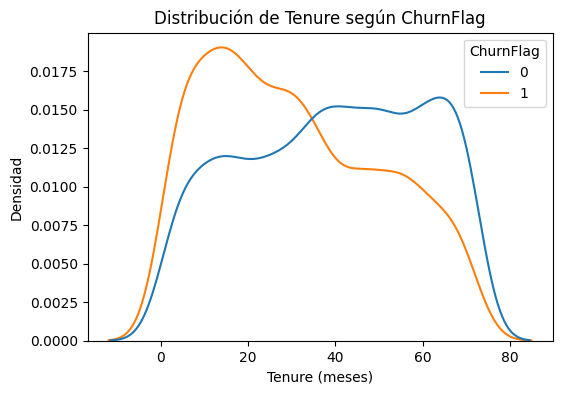

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tomo los datos de tenure y churn
tenure_churn = run_query("SELECT tenure, ChurnFlag FROM churn")

plt.figure(figsize=(6,4))
sns.kdeplot(data=tenure_churn, x='tenure', hue='ChurnFlag', common_norm=False)
plt.title('Distribución de Tenure según ChurnFlag')
plt.xlabel('Tenure (meses)')
plt.ylabel('Densidad')
plt.show()


A partir de estas consultas y gráficas, obtuve una comprensión inicial de las diferencias en la duración del servicio y los cargos mensuales entre quienes se quedan y quienes abandonan.
